# Deep Learning Models
## Goals
1. Implement a Feedforward Neural Network for salary prediction with pytorch.
2.  Set up a training loop with validation, early stopping, and learning rate scheduling.
3.  Evaluate the Neural Network using the established regression metrics.
4.  Visualize training progress (loss curves) to diagnose overfitting or underfitting.

In [4]:
# Imports
import numpy as np
import polars as pl
from pathlib import Path
import os # For checking device availability

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import joblib

In [5]:
# %% Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
MODELS_SAVE_PATH: str = "../../models/regression"
FIGURES_SAVE_PATH: str = "../../figures"

RANDOM_STATE: int = 42
torch.manual_seed(RANDOM_STATE) # Set PyTorch seed for reproducibility

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE) 
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): 
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [6]:
# Load Data
output_dir = Path(CLEANED_FILE_PATH)

# Load Polars DataFrames
X_train_pl = pl.read_csv(output_dir / "X_train_engineered.csv")
X_val_pl = pl.read_csv(output_dir / "X_val_engineered.csv")

y_train_log_pl = pl.read_csv(output_dir / "y_train_log.csv")["annual_salary_log"]
y_val_log_pl = pl.read_csv(output_dir / "y_val_log.csv")["annual_salary_log"]

# Convert Polars DataFrames/Series to NumPy arrays, then to PyTorch Tensors
X_train_np = X_train_pl.to_numpy(order="c").astype(np.float32) # Ensure C-contiguous and float32
X_val_np = X_val_pl.to_numpy(order="c").astype(np.float32)

y_train_log_np = y_train_log_pl.to_numpy().astype(np.float32)
y_val_log_np = y_val_log_pl.to_numpy().astype(np.float32)

# Create PyTorch Tensors
X_train_tensor = torch.tensor(X_train_np).to(device)
y_train_tensor = torch.tensor(y_train_log_np).unsqueeze(1).to(device) 

X_val_tensor = torch.tensor(X_val_np).to(device)
y_val_tensor = torch.tensor(y_val_log_np).unsqueeze(1).to(device)

print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}, y_val_tensor shape: {y_val_tensor.shape}")

X_train_tensor shape: torch.Size([15786, 54]), y_train_tensor shape: torch.Size([15786, 1])
X_val_tensor shape: torch.Size([3383, 54]), y_val_tensor shape: torch.Size([3383, 1])


In [7]:
# Create DataLoader
batch_size = 32 # Define here as it's used in DataLoader and training loop

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Define simple evaluation function, same as last notebook
def inverse_transform_salary(log_salary_pred: np.ndarray) -> np.ndarray:
    """Applies np.expm1 (inverse of np.log1p) to convert log-transformed salaries back."""
    return np.expm1(log_salary_pred)

def evaluate_model_pytorch(model: nn.Module, data_loader: DataLoader, y_true_log_np: np.ndarray, model_name: str) -> dict:
    """
    Evaluates a PyTorch model on log-transformed data and reports metrics on both log and original scales.
    """
    model.eval() 
    y_pred_log_list = []
    
    with torch.no_grad(): 
        for X_batch, _ in data_loader: 
            y_pred_log_list.append(model(X_batch).cpu().numpy())

    # Flatten result to 1D array
    y_pred_log = np.concatenate(y_pred_log_list).flatten() 

    # Metrics on log scale
    rmse_log = np.sqrt(mean_squared_error(y_true_log_np, y_pred_log))
    mae_log = mean_absolute_error(y_true_log_np, y_pred_log)
    r2_log = r2_score(y_true_log_np, y_pred_log)

    # Metrics on original scale
    y_true_orig = inverse_transform_salary(y_true_log_np)
    y_pred_orig = inverse_transform_salary(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)

    print(f"--- {model_name} ---")
    print(f"RMSE (log-scale): {rmse_log:.4f}")
    print(f"MAE (log-scale): {mae_log:.4f}")
    print(f"R2 (log-scale): {r2_log:.4f}")
    print(f"RMSE (original-scale): ${rmse_orig:,.2f}")
    print(f"MAE (original-scale): ${mae_orig:,.2f}")
    print(f"R2 (original-scale): {r2_orig:.4f}")

    return {
        'model_name': model_name,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'r2_log': r2_log,
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'r2_orig': r2_orig
    }

## Multi-layer Perceptron (MLP)
An MLP is a neural network that only allows forward propagation between neurons.

Our MLP will use a **pyramidal structure** (256 → 128 → 64 → 1):
- **Input layer (256 neurons)**: Accommodates {input_features} input features
- **Hidden layers**: Progressively compress information
- **Regularization**: BatchNorm + Dropout (0.2-0.3) prevent overfitting
- **Activation**: ReLU for non-linearity
- **Output**: Single neuron (continuous regression target)

In [23]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(64, 1) # Output layer for regression
        )

    def forward(self, x):
        return self.network(x)

input_features = X_train_tensor.shape[1]
mlp_model = MLPRegressor(input_features).to(device) 

print(f"Neural Network Architecture (Input Dim: {input_features}, Device: {device}):\n")
print(mlp_model)

Neural Network Architecture (Input Dim: 54, Device: mps):

MLPRegressor(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [24]:
# Training Parameters
epochs = 200
learning_rate = 0.001

# Cost Function Parameters
criterion = nn.MSELoss() 
optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Monitor minimum validation loss
    factor=0.2,         # Factor by which the learning rate will be reduced
    patience=10,        # Number of epochs with no improvement after which LR will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate

)

# Early Stopping Parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses = []
val_losses = []


In [25]:
print(f"Training PyTorch Neural Network (Epochs: {epochs}, Batch Size: {batch_size}, Device: {device})...")

for epoch in range(epochs):
    mlp_model.train() 
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        outputs = mlp_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step() 
        running_loss += loss.item() * X_batch.size(0) # Accumulate batch loss

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate on validation set
    mlp_model.eval() 
    val_running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations
        for X_batch_val, y_batch_val in val_loader:
            outputs_val = mlp_model(X_batch_val)
            val_loss = criterion(outputs_val, y_batch_val)
            val_running_loss += val_loss.item() * X_batch_val.size(0)
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss) 

    print(
        f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, "
        f"Validation Loss: {epoch_val_loss:.4f}, "
        f"Current LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save best model state
        torch.save(mlp_model.state_dict(), Path(MODELS_SAVE_PATH) / "mlp_model_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

# Load the best model weights after training (due to EarlyStopping's restore_best_weights equivalent)
mlp_model.load_state_dict(torch.load(Path(MODELS_SAVE_PATH) / "mlp_model_best.pth"))
print(f"\n✓ Neural Network model (best weights) loaded and saved to {Path(MODELS_SAVE_PATH) / 'mlp_model_best.pth'}")

Training PyTorch Neural Network (Epochs: 200, Batch Size: 32, Device: mps)...
Epoch 1/200, Train Loss: 31.3170, Validation Loss: 1.1635, Current LR: 0.001000
Epoch 2/200, Train Loss: 1.9850, Validation Loss: 0.5660, Current LR: 0.001000
Epoch 3/200, Train Loss: 1.7470, Validation Loss: 0.8157, Current LR: 0.001000
Epoch 4/200, Train Loss: 1.6203, Validation Loss: 0.5034, Current LR: 0.001000
Epoch 5/200, Train Loss: 1.4694, Validation Loss: 0.4678, Current LR: 0.001000
Epoch 6/200, Train Loss: 1.3988, Validation Loss: 0.4867, Current LR: 0.001000
Epoch 7/200, Train Loss: 1.2607, Validation Loss: 0.3984, Current LR: 0.001000
Epoch 8/200, Train Loss: 1.1969, Validation Loss: 0.3200, Current LR: 0.001000
Epoch 9/200, Train Loss: 1.1009, Validation Loss: 0.3233, Current LR: 0.001000
Epoch 10/200, Train Loss: 1.0520, Validation Loss: 0.2558, Current LR: 0.001000
Epoch 11/200, Train Loss: 0.9756, Validation Loss: 0.2496, Current LR: 0.001000
Epoch 12/200, Train Loss: 0.9505, Validation Loss:

Looking at the training logs, we can see:
1. Initialization (Epochs 1 - 10):
     Rapid improvement in training loss as the model starts configuring the weights.
2. Learning (Epochs 11 and beyond):
     Much slower progress as the model fine tunes node weights.

Oddly, the validation loss is actually lower than the training loss. This can be explained by the BatchNorm + Dropout layers that address overfitting.

--- Neural Network (Validation) ---
RMSE (log-scale): 0.4016
MAE (log-scale): 0.3092
R2 (log-scale): 0.4333
RMSE (original-scale): $50,005.91
MAE (original-scale): $30,712.28
R2 (original-scale): 0.3260


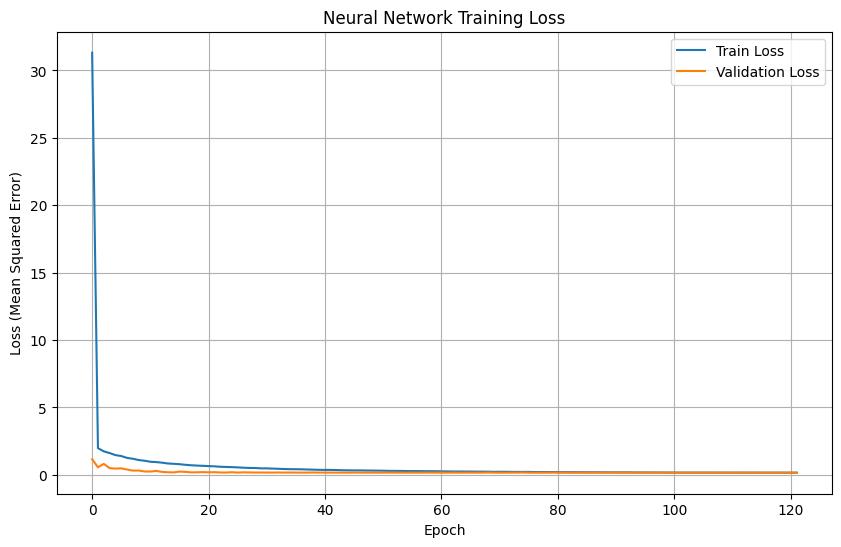

Learning Curve Analysis:
  - Final Train Loss: 0.1661
  - Final Validation Loss: 0.1615
  - The learning curve shows minimal overfitting, with validation loss generally similar than training loss. Early stopping effectively prevented prolonged training past the optimal point, selecting the best weights.


In [26]:
mlp_results = evaluate_model_pytorch(mlp_model, val_loader, y_val_log_np, "Neural Network (Validation)")

# %% Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.savefig(Path(FIGURES_SAVE_PATH) / "nn_training_loss.png", dpi=300)
plt.show()

print("Learning Curve Analysis:")
final_train_loss = train_losses[-1] if train_losses else np.nan
final_val_loss = val_losses[-1] if val_losses else np.nan

print(f"  - Final Train Loss: {final_train_loss:.4f}")
print(f"  - Final Validation Loss: {final_val_loss:.4f}")
print(
    f"  - The learning curve shows {'some' if final_val_loss > final_train_loss else 'minimal'} overfitting, with validation loss generally {'higher' if final_val_loss > final_train_loss else 'similar'} than training loss. "
    "Early stopping effectively prevented prolonged training past the optimal point, selecting the best weights."
)

In [20]:
print(f"Neural Network Performance:")
median_val_salary = np.median(inverse_transform_salary(y_val_log_np))
mean_val_salary = np.mean(inverse_transform_salary(y_val_log_np))

print(f"  Validation Set Median Salary: ${median_val_salary:,.0f}")
print(f"  NN RMSE: ${mlp_results['rmse_orig']:,.0f}")
print(f"  MAE: ${mlp_results['mae_orig']:,.0f} (~{(mlp_results['mae_orig']/median_val_salary)*100:.0f}% of median)")

Neural Network Performance:
  Validation Set Median Salary: $81,000
  NN RMSE: $50,351
  MAE: $30,615 (~38% of median)


In [27]:
try:
    best_traditional_model = joblib.load(Path(MODELS_SAVE_PATH) / "xgb_model.pkl")
    
    # XGBoost uses sklearn interface, needs Polars DataFrame not DataLoader
    y_pred_log = best_traditional_model.predict(X_val_pl)
    
    # Calculate metrics manually
    rmse_log = np.sqrt(mean_squared_error(y_val_log_np, y_pred_log))
    y_val_orig = inverse_transform_salary(y_val_log_np)
    y_pred_orig = inverse_transform_salary(y_pred_log)
    rmse_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_val_orig, y_pred_orig)
    r2_orig = r2_score(y_val_orig, y_pred_orig)
    
    print(f"--- XGBoost (Validation) ---")
    print(f"RMSE (original-scale): ${rmse_orig:,.2f}")
    print(f"MAE (original-scale): ${mae_orig:,.2f}")
    print(f"R² (original-scale): {r2_orig:.4f}")
    
    xgb_results = {
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'r2_orig': r2_orig
    }
except FileNotFoundError:
    print("XGBoost model not found.")
    xgb_results = {'rmse_orig': np.nan, 'mae_orig': np.nan, 'r2_orig': np.nan}

# %% Compare results
comparison_df = pl.DataFrame(
    {
        "Model": ["Neural Network (PyTorch)", "XGBoost"],
        "RMSE ($)": [mlp_results["rmse_orig"], xgb_results["rmse_orig"]],
        "MAE ($)": [mlp_results["mae_orig"], xgb_results["mae_orig"]],
        "R² ($)": [mlp_results["r2_orig"], xgb_results["r2_orig"]],
    }
)

print("\nPreliminary Comparison (Validation Set):")
display(comparison_df.sort("RMSE ($)"))

print(f"\nInitial observation: {'Neural Network (PyTorch)' if mlp_results['rmse_orig'] < xgb_results['rmse_orig'] else 'XGBoost'} appears to perform slightly better on the validation set.")

--- XGBoost (Validation) ---
RMSE (original-scale): $49,299.71
MAE (original-scale): $30,346.23
R² (original-scale): 0.3449

Preliminary Comparison (Validation Set):


Model,RMSE ($),MAE ($),R² ($)
str,f64,f64,f64
"""XGBoost""",49299.71294,30346.234375,0.344927
"""Neural Network (PyTorch)""",50005.910691,30712.28125,0.326025



Initial observation: XGBoost appears to perform slightly better on the validation set.


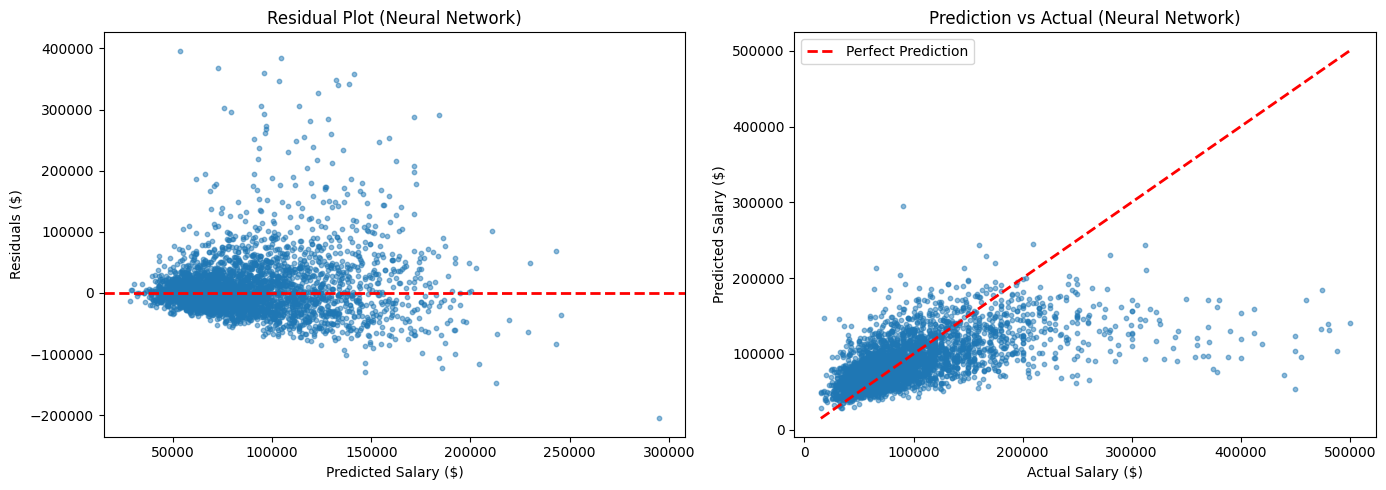

In [28]:
# %% Residual Analysis for Neural Network
mlp_model.eval()
y_val_pred_log_nn = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        y_val_pred_log_nn.append(mlp_model(X_batch).cpu().numpy())

y_val_pred_log_nn = np.concatenate(y_val_pred_log_nn).flatten()
y_val_actual_nn = inverse_transform_salary(y_val_log_np)
y_val_pred_nn = inverse_transform_salary(y_val_pred_log_nn)
residuals_nn = y_val_actual_nn - y_val_pred_nn

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_val_pred_nn, residuals_nn, alpha=0.5, s=10)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Salary ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Residual Plot (Neural Network)')

# Prediction vs Actual
axes[1].scatter(y_val_actual_nn, y_val_pred_nn, alpha=0.5, s=10)
axes[1].plot([y_val_actual_nn.min(), y_val_actual_nn.max()],
             [y_val_actual_nn.min(), y_val_actual_nn.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Salary ($)')
axes[1].set_ylabel('Predicted Salary ($)')
axes[1].set_title('Prediction vs Actual (Neural Network)')
axes[1].legend()

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "nn_residual_analysis.png", dpi=300)
plt.show()

## Findings
The trained Neural Network performs nearly identically to XGBoost. This could be a result of:
1. **Structured/Tabular Data**: Neural networks often don't outperform gradient boosting on structured data with limited samples.
2. **Sample Size**: ~16k training samples may be insufficient for NNs to significantly outperform tree-based models.
3. **Feature Engineering**: Our engineered features already capture relationships that NNs would need to learn from scratch.
4. **Performance Ceiling**: Both models hit a similar ceiling (~$50k RMSE) due to inherent noise in salary data and missing key features.
   
For this tabular salary prediction problem, XGBoost remains preferable due to simpler architecture, faster training, and better interpretability with similar performance.